### Introduction
The use of emails for communication has been growing consistently in the digital era. However, unwanted emails such as ads and scams have also been growing in tandem. This do not only fill up the mail box, but some are also attempts at scamming and when successful, they may lead to financial losses or the leaking of sensitive data. To counter this, machine learning has been used to classify emails as either spam or not spam, and move the spams to a dedicated folder where they can be deleted.
We implement a machine learning algorithm that can be used to filter emails based on a logistic regression.

### Objective
The objective of this exercise is to develop a machine learning algorithm that can classify an email as a spam or not spam. We will use the Spam Emails Dataset for Classification and Filtering downloaded from Kaggle. [https://www.kaggle.com/datasets/abdallahwagih/spam-emails]
This dataset contains a collection of emails, categorized into two classes: "Spam" and "Non-Spam" (often referred to as "Ham"). These emails have been carefully curated and labeled to aid in the development of spam email detection models.

In [62]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import string
import joblib
import os
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dominic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dominic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dominic/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [17]:
# Load the dataset
df = pd.read_csv("../data/dataset.csv")
# Printing first five rows of the dataset
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The dataset includes the following features:
Category: Categorizes each email as either "Spam" or "Ham" (Non-Spam).
Message: The content of the email, including the subject line and message body.

### Data Exploration and Cleaning
Next, we will have a look at the dataset and clean it.

In [18]:
# Check the data shape
df.shape

(5572, 2)

The dataset has 5,572 rows and 2 columns as indicated above.

In [19]:
# Check the data type and missing values
print(df.info())
print(df.isnull().sum())  # Count missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
Category    0
Message     0
dtype: int64


Both categories are object data types. There are no missing values in the dataset.

In [20]:
# Compare the value of each text, Spam vs Non Spam
print(df['Category'].value_counts())


Category
ham     4825
spam     747
Name: count, dtype: int64


/var/folders/x3/3chfptdn2wd3_c3_4mgf48km0000gn/T/ipykernel_79530/2058271711.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Category'], palette='coolwarm')


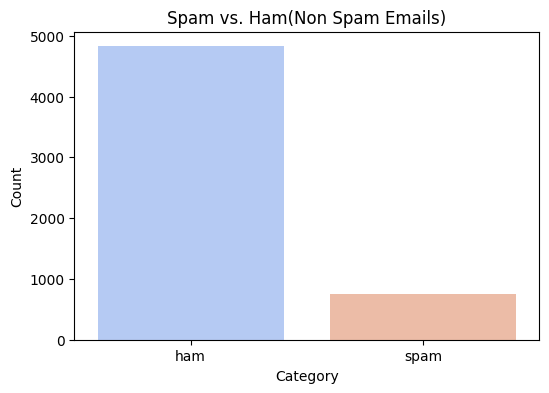

In [21]:
# Visualize the categories
plt.figure(figsize=(6,4))
sns.countplot(x=df['Category'], palette='coolwarm')

plt.title("Spam vs. Ham(Non Spam Emails)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

There are 4,825 'Ham' (Non Spam)emails and 747 spam emails in our dataset.

### Compare average message length of the two categories

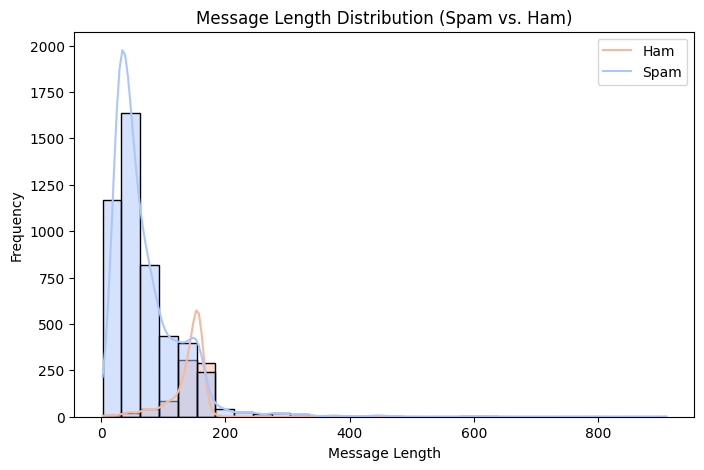

In [22]:
df["Message_Length"] = df["Message"].apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="Message_Length", hue="Category", bins=30, kde=True, palette="coolwarm")

plt.title("Message Length Distribution (Spam vs. Ham)")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.legend(["Ham", "Spam"])
plt.show()

We observe the lengths of spam and regular (ham) emails. It is interesting to see that spam emails are much longer on average as compared to regular emails. We can deduce that spam emails tend to be more wordy possibly because they try to confuse the reader and prompt them into taking a decision. Regular emails tend to be shorter and more precise.

### Average words per email, Ham vs Spam

Average Words of Spam Emails: 27.87817938420348
Average Words of Ham Emails: 17.425699481865284


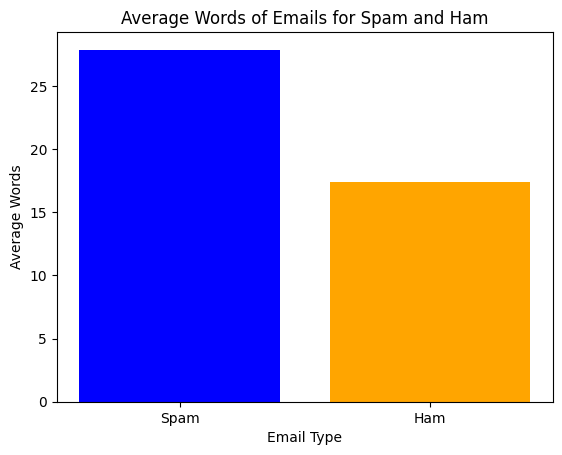

In [32]:
# Let's explore the average no of words per email in ham vs spam
df['num_words'] = df['Message'].apply(word_tokenize).apply(len)

avg_word_spam = df[df['Category'] == 'spam']['num_words'].mean()
avg_word_ham = df[df['Category'] == 'ham']['num_words'].mean()
print("Average Words of Spam Emails:", avg_word_spam)
print("Average Words of Ham Emails:", avg_word_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_word_spam, avg_word_ham], color=['Blue', 'orange'])
plt.title('Average Words of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Words')
plt.show()

The average words for spam emails is much higher than for ham emails. We can deduce that spam emails tend to be more wordy, than regular emails. This will be helpful when creating the filter to catch spam messages.

### Most common words in Spam vs Ham

In [40]:
#Convert the categories into numerical variables
df["Category"] = df["Category"].map({"ham": 0, "spam": 1})

# Function to clean and tokenize text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stopwords.words("english")]  # Remove stopwords
    return words

# Apply function to messages
df["Tokenized_Message"] = df["Message"].apply(preprocess_text)

# Flatten lists of words
all_words_spam = [word for msg in df[df["Category"] == 1]["Tokenized_Message"] for word in msg]
all_words_ham = [word for msg in df[df["Category"] == 0]["Tokenized_Message"] for word in msg]

# Get most common words
spam_word_freq = Counter(all_words_spam).most_common(20)
ham_word_freq = Counter(all_words_ham).most_common(20)

# Display results
print("Most Common Spam Words:", spam_word_freq)
print("Most Common Ham Words:", ham_word_freq)


Most Common Spam Words: [('call', 344), ('free', 216), ('2', 173), ('txt', 150), ('u', 145), ('ur', 144), ('mobile', 123), ('text', 120), ('4', 119), ('stop', 115), ('claim', 111), ('reply', 101), ('prize', 90), ('get', 83), ('new', 69), ('send', 68), ('nokia', 65), ('cash', 62), ('urgent', 62), ('win', 60)]
Most Common Ham Words: [('u', 985), ('im', 451), ('2', 309), ('get', 303), ('ltgt', 276), ('ok', 273), ('dont', 265), ('go', 250), ('ur', 246), ('ill', 238), ('got', 232), ('know', 232), ('like', 231), ('call', 231), ('come', 227), ('good', 224), ('love', 190), ('time', 189), ('day', 188), ('4', 174)]


There are plenty of commom spam words that we can relate with. For instance, call, free, text, cash, urgent, claim and prize. These tend to lure the receiver into thinking there is a reward for an action they take and this is how they end up getting scammed. we can visualize this in a World Cloud map.

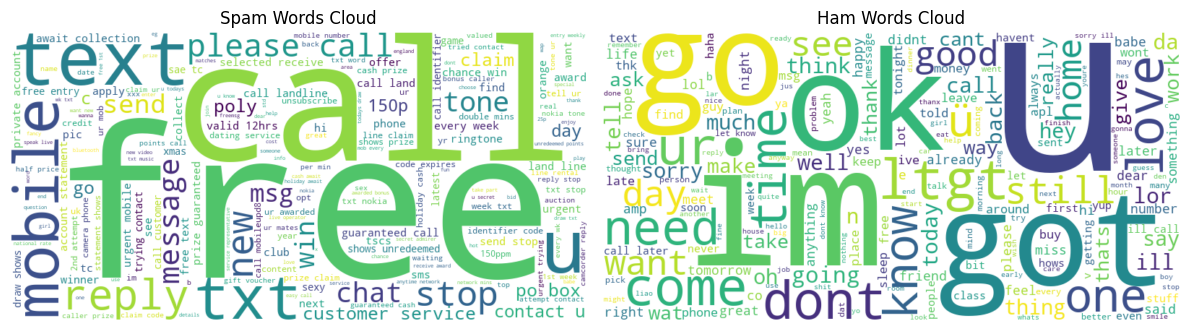

In [44]:
# Create a world cloud
# Join the spam and ham words into one
spam_words = ' '.join(all_words_spam)
ham_words = ' '.join(all_words_ham)

# Create the word clouds
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)

# Plot the figure
plt.figure(figsize=(12, 6))

# Spam Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title("Spam Words Cloud")
plt.axis('off')

# Ham Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title("Ham Words Cloud")
plt.axis('off')

plt.tight_layout()
plt.show()


### Prepare the data for machine learning

We first split the data into features and the corresponding labels since we already converted the data into numerical values (o for ham and 1 for spam). Next, we split the data into training and test sets on an 80-20 rule. We then use the TF_IDF vectorizer from scikit-learn to calculate the tf-idf values. lastly, we fit and transform the training and the test data

In [46]:
# Split data into features (X) and labels (y)
X = df["Message"] 
y = df["Category"] 

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Model Training

#### 1. Logistic Regression

Logistic Regression is a machine learning algorithm that estimates the probability of an event occurring. For instance, in this case, whether an email is a spam or not (IBM. (n.d.). What is logistic regression? https://www.ibm.com/think/topics/logistic-regression.)
It is used in both classification and predictive problems. A logit transformation is applied on the odds represented by the formula:

* Logit(pi) = 1/(1+ exp(-pi))

* ln(pi/(1-pi)) = Beta_0 + Beta_1*X_1 + … + B_k*K_k

logit(pi) is the dependent or response variable. x is the independent variable.  The beta parameter, or coefficient, in this model is commonly estimated through maximum likelihood estimation (MLE). For binary classification, a probability less than .5 will predict 0 while a probability greater than 0 will predict 1.

In [48]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_log_reg = log_reg.predict(X_test_tfidf)

# Print the results
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Accuracy: 0.9739910313901345
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



The logistic regression model has an Accuracy of 0.97 (or approximately 97.4%) This means that the model correctly predicted the class (0 or 1) for about 97.4% of the samples in the test dataset. This is a very high accuracy, suggesting the model performs well overall.
The model also performs  well in predicting class 0, the ham or non spam emails, achieving perfect recall and high precision.
The large difference in support between the ham and spam emails could potentially indicate an imbalanced dataset.
Next we implement ROC curve to further test the model's performance.



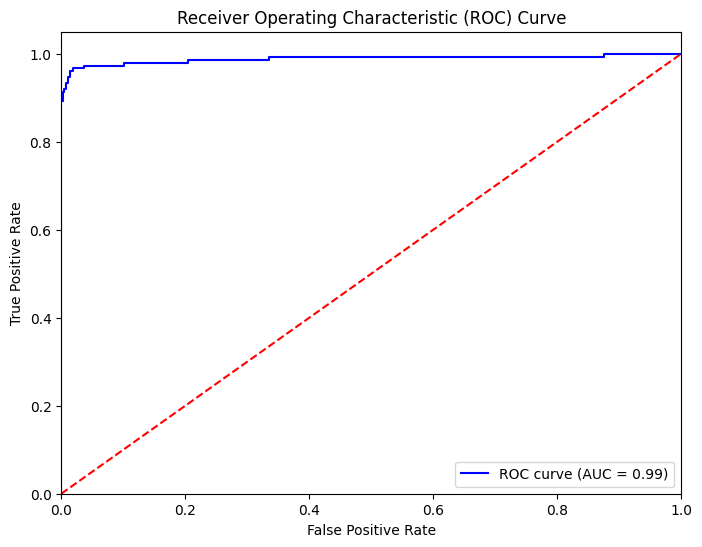

ROC AUC: 0.99


In [49]:
from sklearn.metrics import roc_curve, auc
# Get the predicted probabilities for the positive class (spam = 1)
y_prob_log_reg = log_reg.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_log_reg)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f'ROC AUC: {roc_auc:.2f}')

The Receiver Operator Characteristic (ROC) of the Area Under the Curve (AUC) graph is interpreted as follows

* AUC = 1: Perfect classifier.

* AUC = 0.5: No discrimination ability.

* AUC < 0.5: The model is performing worse than random guessing.

In this case the AUC is 0.99 which is very high! Revisiting the count of the distinct values of our categories,
* ham     4825
* spam     747
The classes are indeed very imbalanced and our model is biased towards predicting the ham class. Class imbalance can be handled in different ways (Tang, 2023). This includes:
* Random oversampling
* Random undersampling
* Oversampling with SMOTE
* Oversampling with ADASYN
* Undersampling with Tomek Link
* Oversampling with SMOTE, then undersample with TOMEK Link (SMOTE-Tomek)

We will try the oversampling with SMOTE to balance the classes.


SMOTE is a method of oversampling. SMOTE creates synthetic data points by interpolating between the minority data points that are close by to one another.

In [50]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE and apply it to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Check new class distribution after SMOTE
print("New class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

New class distribution after SMOTE:
Category
1    3859
0    3859
Name: count, dtype: int64


In [51]:
# Train the Logistic Regression model again with balanced data
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_smote, y_train_smote)

# Predict and evaluate on the test set
y_pred_log_reg_smote = log_reg.predict(X_test_tfidf)

# Evaluate the model
print("Logistic Regression Accuracy (SMOTE):", accuracy_score(y_test, y_pred_log_reg_smote))
print(classification_report(y_test, y_pred_log_reg_smote))

Logistic Regression Accuracy (SMOTE): 0.9856502242152466
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.93      0.96      0.95       149

    accuracy                           0.99      1115
   macro avg       0.96      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



The model accuracy has increased to 98.57%. This shows that the the model is now performing well on both the ham and spam classes. The precision for spam is 93%, indicating that most of the emails predicted as spam are indeed spam. The F1-score for spam is 0.95, showing a strong balance between precision and recall.

Evaluating using a ROC curve

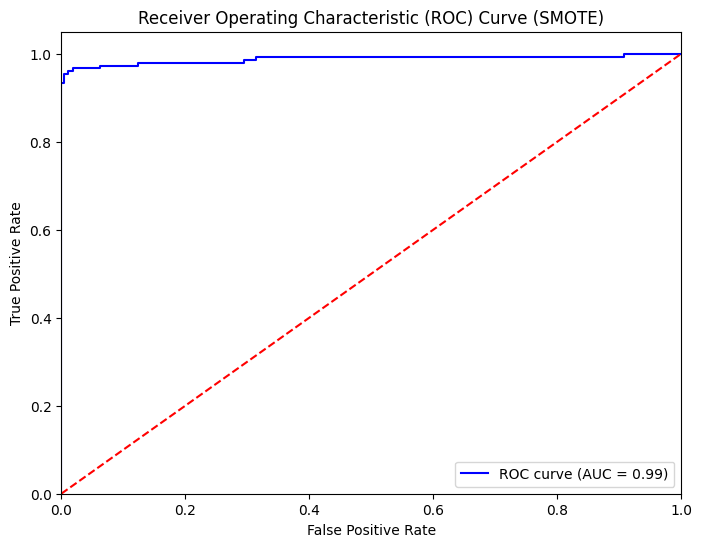

ROC AUC (SMOTE): 0.99


In [52]:
# Get the predicted probabilities for the positive class (spam = 1)
y_prob_log_reg_smote = log_reg.predict_proba(X_test_tfidf)[:, 1]  # Only the probability of the positive class
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_prob_log_reg_smote)

# Compute AUC
roc_auc_smote = auc(fpr_smote, tpr_smote)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_smote, tpr_smote, color='blue', label=f'ROC curve (AUC = {roc_auc_smote:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (no skill)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (SMOTE)')
plt.legend(loc='lower right')
plt.show()

print(f'ROC AUC (SMOTE): {roc_auc_smote:.2f}')


The AUC is 0.99 which shows a high accuracy for the model. We explore Linear regression next.

#### 2. Linear Regression

Linear regression is used to predict a value (dependent variable) based on the values of other variables (independent variables). For instance, one might want to predict the salary based on years of experience. It is commonly used for continous values as opposed to categorical variables.

In [55]:
# Train the Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train_smote, y_train_smote)

# Predict continuous values on the test set
y_pred_linear_reg = linear_reg.predict(X_test_tfidf)

# Convert continuous predictions to binary (0 or 1)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred_linear_reg]

# Model Evaluation
print("Linear Regression Accuracy:", accuracy_score(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary))

Linear Regression Accuracy: 0.8215246636771301
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       966
           1       0.41      0.81      0.55       149

    accuracy                           0.82      1115
   macro avg       0.69      0.81      0.72      1115
weighted avg       0.89      0.82      0.84      1115



The linear regression model has a lower accuracy than the logistic regression model (82%). The precision for spam is 96%, indicating that most of the emails predicted as spam are spam.

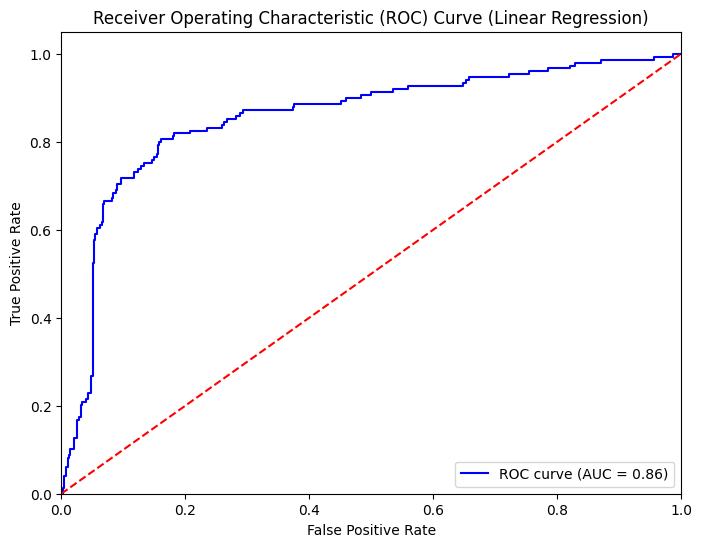

ROC AUC (Linear Regression): 0.86


In [56]:
# Compute ROC curve and AUC for Linear Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_linear_reg)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', label=f'ROC curve (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (no skill)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Linear Regression)')
plt.legend(loc='lower right')
plt.show()

print(f'ROC AUC (Linear Regression): {roc_auc_lr:.2f}')

The AUC is 0.86 which shows that the model has a high accuracy.

#### 3. Perceptron Classifier
The Perceptron is a linear machine learning algorithm for binary classification tasks. Invented by Frank Rosenblatt in 1958, it is one of the earliest supervised machine learning Algorithm. The Perceptron algorithm looks to minimize the objective function in order to predict the correct label for the data set.

The classifier consists of a single node or neuron that takes a row of data as input and predicts a class label. 

* Activation = Weights * Inputs + Bias

If the activation is above 0.0, the model will output 1.0; otherwise, it will output 0.0.

* Predict 1: If Activation > 0.0
* Predict 0: If Activation <= 0.0

The Perceptron classifier is actually classified as a simple neural network. 

##### Implementing a Perceptron Classifier

In [58]:
# Train the Perceptron model
perceptron = Perceptron(max_iter=1000, random_state=42)
perceptron.fit(X_train_smote, y_train_smote)

Perceptron(random_state=42)

In [59]:
# Predict on the test set
y_pred_perceptron = perceptron.predict(X_test_tfidf)

In [61]:
# Model evaluation
print("Perceptron Model Accuracy:", accuracy_score(y_test, y_pred_perceptron))
print(classification_report(y_test, y_pred_perceptron))

Perceptron Model Accuracy: 0.9739910313901345
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       966
           1       0.88      0.93      0.91       149

    accuracy                           0.97      1115
   macro avg       0.93      0.96      0.95      1115
weighted avg       0.97      0.97      0.97      1115



The overall accuracy of the perceptron classifier is remarkable at 97%. The precision is 88% meaning that 88 per cent of emails predicted as spam are actually spam. The recall is 93% meaning the model correctly identified 93% of the emails as spam.

### Exporting the Models

In [ ]:
# Save Logistic Regression
joblib.dump(log_reg, "models/logistic_regression.pkl")

# Save Linear Regression
joblib.dump(linear_reg, "models/linear_regression.pkl")

# Save Perceptron
joblib.dump(perceptron, "models/perceptron.pkl")